## 使用QLORA訓練白話文和文言文互轉的模型(台大資工所2024年應用深度學習作業3)
### 1. 作業目標
- 本次作業目標是使用QLORA訓練一個白話文和文言文互轉的模型。
- 使用的基礎模型是`zake7749/gemma-2-2b-it-chinese-kyara-dpo`，這是一個Google Gemma2經過Instrunction Tuned及DPO之後的模型。
- 本次作業的資料集是台大資工作業提供的，並沒有經過資料清理，是用簡體硬轉成繁體的，資料集問題很多，這是一個包含白話文和文言文的資料集。
### 2. 作業步驟
- 本次作業的步驟如下：
  1. 資料前處理
  2. 使用QLORA訓練模型
  3. 模型測試
### 3. 訓練監控
- 本次作業的訓練監控如下：
  1. 訓練過程中的loss
  2. 使用wandb記錄訓練過程
  3. 調整各種參數觀察訓練結果


In [1]:
!pip install transformers datasets torch bitsandbytes peft wandb trl flash-attn nvidia-ml-py3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 抓取訓練資料，裡面包含五萬筆白話文->文言文資料

In [2]:
!wget https://github.com/shhuangmust/AI/raw/refs/heads/master/train.json

--2025-04-12 11:39:59--  https://github.com/shhuangmust/AI/raw/refs/heads/master/train.json
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shhuangmust/AI/refs/heads/master/train.json [following]
--2025-04-12 11:40:00--  https://raw.githubusercontent.com/shhuangmust/AI/refs/heads/master/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2940614 (2.8M) [application/octet-stream]
Saving to: ‘train.json’

train.json          100%[===================>]   2.80M  --.-KB/s    in 0.01s   

2025-04-12 11:40:01 (193 MB/s) - ‘train.json’ saved [2940614/2940614]



- 採用gemma-2-2b-it-chinese-kyara-dpo基礎模型
- 4bit的量化模型來節省訓練記憶體
- 要產生文言文，因此採用AutoModelForCausalLM

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model_id = "zake7749/gemma-2-2b-it-chinese-kyara-dpo"



model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config,
                      attn_implementation='eager',
                      cache_implementation=None,
                      use_cache=False,)

tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)
model.to('cuda')

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/208 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_

In [4]:
print(model)

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_

## 讀取資料
- 將資料轉換成gemma2的讀取格式

In [5]:
from datasets import load_dataset
dataset = load_dataset('json', data_files="train.json", split="train").shuffle(seed=42)

def generate_prompt(data_point):
    prefix_text = '你是一個使用繁體中文的人工智慧助理，下面是問題的描述，以及對應的答案，請照著問題並且回答答案。\n\n'
    text = f"<start_of_turn>user {prefix_text} {data_point['instruction']} <end_of_turn>\n<start_of_turn>model {data_point['output']} <end_of_turn>"
    return text
# Add the 'prompt' column to the dataset
text_column = [generate_prompt(data_point) for data_point in dataset]
dataset = dataset.add_column("prompt", text_column)
# Tokenize the dataset
dataset = dataset.shuffle(seed=1234)
dataset = dataset.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
# Split the dataset into training and testing
dataset = dataset.train_test_split(test_size=0.2)
train_data = dataset["train"]
test_data = dataset["test"]

Generating train split: 0 examples [00:00, ? examples/s]

Flattening the indices:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
print(train_data[200])

{'id': '222a41c8-a054-477b-9bb4-b8680c57467e', 'instruction': '將下麵句子翻譯成文言文：\n五月初五，嚴令大都禁止飲酒，違犯者沒收其傢財散發給貧苦百姓。', 'output': '五月癸巳，申嚴大都酒禁，犯者籍其傢貲，散之貧民。', 'prompt': '<start_of_turn>user 你是一個使用繁體中文的人工智慧助理，下面是問題的描述，以及對應的答案，請照著問題並且回答答案。\n\n 將下麵句子翻譯成文言文：\n五月初五，嚴令大都禁止飲酒，違犯者沒收其傢財散發給貧苦百姓。 <end_of_turn>\n<start_of_turn>model 五月癸巳，申嚴大都酒禁，犯者籍其傢貲，散之貧民。 <end_of_turn>', 'input_ids': [2, 106, 1645, 30485, 115346, 7060, 238249, 236969, 50039, 11043, 235823, 68631, 141771, 235365, 45992, 235427, 17974, 235370, 35875, 235365, 21318, 236583, 237236, 235370, 48310, 235365, 237261, 236160, 236523, 17974, 144100, 33226, 48310, 235362, 109, 155632, 235543, 238567, 90959, 204032, 235636, 235642, 235904, 235642, 235465, 108, 134063, 236107, 236092, 235365, 239420, 236697, 235469, 235662, 61509, 237349, 236408, 235365, 236875, 237995, 235714, 236678, 236285, 235853, 242625, 237879, 237068, 236683, 237132, 240245, 236954, 101455, 235362, 235248, 107, 108, 106, 2516, 33339, 235612, 242420, 241889, 235365, 237026, 23942

## 找出所有可以進行QLora訓練的層

In [7]:
def find_all_linear_names(peft_model, int4=False, int8=False):
    """Find all linear layer names in the model. reference from qlora paper."""
    cls = torch.nn.Linear
    if int4 or int8:
        import bitsandbytes as bnb
        if int4:
            cls = bnb.nn.Linear4bit
        elif int8:
            cls = bnb.nn.Linear8bitLt
    lora_module_names = set()
    for name, module in peft_model.named_modules():
        if isinstance(module, cls):
            # last layer is not add to lora_module_names
            if 'lm_head' in name:
                continue
            if 'output_layer' in name:
                continue
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    return sorted(lora_module_names)

In [8]:
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model

model.enable_input_require_grads()
model.gradient_checkpointing_enable()

model = prepare_model_for_kbit_training(model)
modules = find_all_linear_names(model)  # Get modules to apply LoRA to
lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
peft_model = get_peft_model(model, lora_config)

In [9]:
print(peft_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma2ForCausalLM(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
        

## 列出可訓練的參數數目跟比例

In [10]:
peft_model.print_trainable_parameters()

trainable params: 83,066,880 || all params: 2,697,408,768 || trainable%: 3.0795


In [11]:
print(modules)

['down_proj', 'gate_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj', 'v_proj']


## 進行PEFT訓練
- 採用trl套件
- 可修改max_steps以調整訓練次數

In [12]:
from trl import SFTConfig
import transformers
from trl import SFTTrainer

trainer = SFTTrainer(
    model=peft_model,
    train_dataset=train_data,
    eval_dataset=test_data,
    peft_config=lora_config,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        max_steps=100,
        learning_rate=2e-4,
        output_dir="output1",
        # dataset_text_field="prompt",
        optim="paged_adamw_32bit",
        save_strategy="steps",
        report_to=None,
        #report_to="wandb",
        logging_steps=1,
        packing=False,
        gradient_checkpointing=True,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
trainer.train()

Truncating train dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ggpeer228 (ggpeer228-must) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,5.827500
2,4.207300
3,3.579900
4,3.040100
5,2.929900
6,2.843700
7,2.698700
8,2.472600
9,2.636300
10,2.384300


TrainOutput(global_step=100, training_loss=2.1115062832832336, metrics={'train_runtime': 710.2711, 'train_samples_per_second': 1.126, 'train_steps_per_second': 0.141, 'total_flos': 1202941942861824.0, 'train_loss': 2.1115062832832336})

## 儲存Adapter
- Huggingface的Token，<font color=red>一定要包含『write』權限</font>
- <font color=red>??????????</font>/peft-model-repo，?????????請輸入自己在huggingface的帳號

In [13]:
peft_model.save_pretrained("peft_model")
repo_name = "paul028/peft-model-repo"  # 替換為你的 repository 名稱
save_directory = "./peft_model"             # 模型儲存的本地路徑

# 上傳模型到 Hugging Face
peft_model.push_to_hub(repo_name)

adapter_model.safetensors:   0%|          | 0.00/332M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/paul028/peft-model-repo/commit/bfa11fe6f8878570c12e6f716e5eff342ee7f4e5', commit_message='Upload model', commit_description='', oid='bfa11fe6f8878570c12e6f716e5eff342ee7f4e5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/paul028/peft-model-repo', endpoint='https://huggingface.co', repo_type='model', repo_id='paul028/peft-model-repo'), pr_revision=None, pr_num=None)

In [118]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto",
)
merged_model = PeftModel.from_pretrained(base_model, "output1/checkpoint-100")
merged_model = merged_model.merge_and_unload()


NameError: name 'AutoModelForCausalLM' is not defined

## 一般來說只需要上傳Adapter即可，要使用LLM時，Adapter+基礎模型即可。這邊直接把兩者合併為(merged_model)

In [102]:
merged_model.save_pretrained("merged_model", safe_serialization=True, push_to_hub=True)
tokenizer.save_pretrained("merged_model", push_to_hub=True)

NameError: name 'merged_model' is not defined

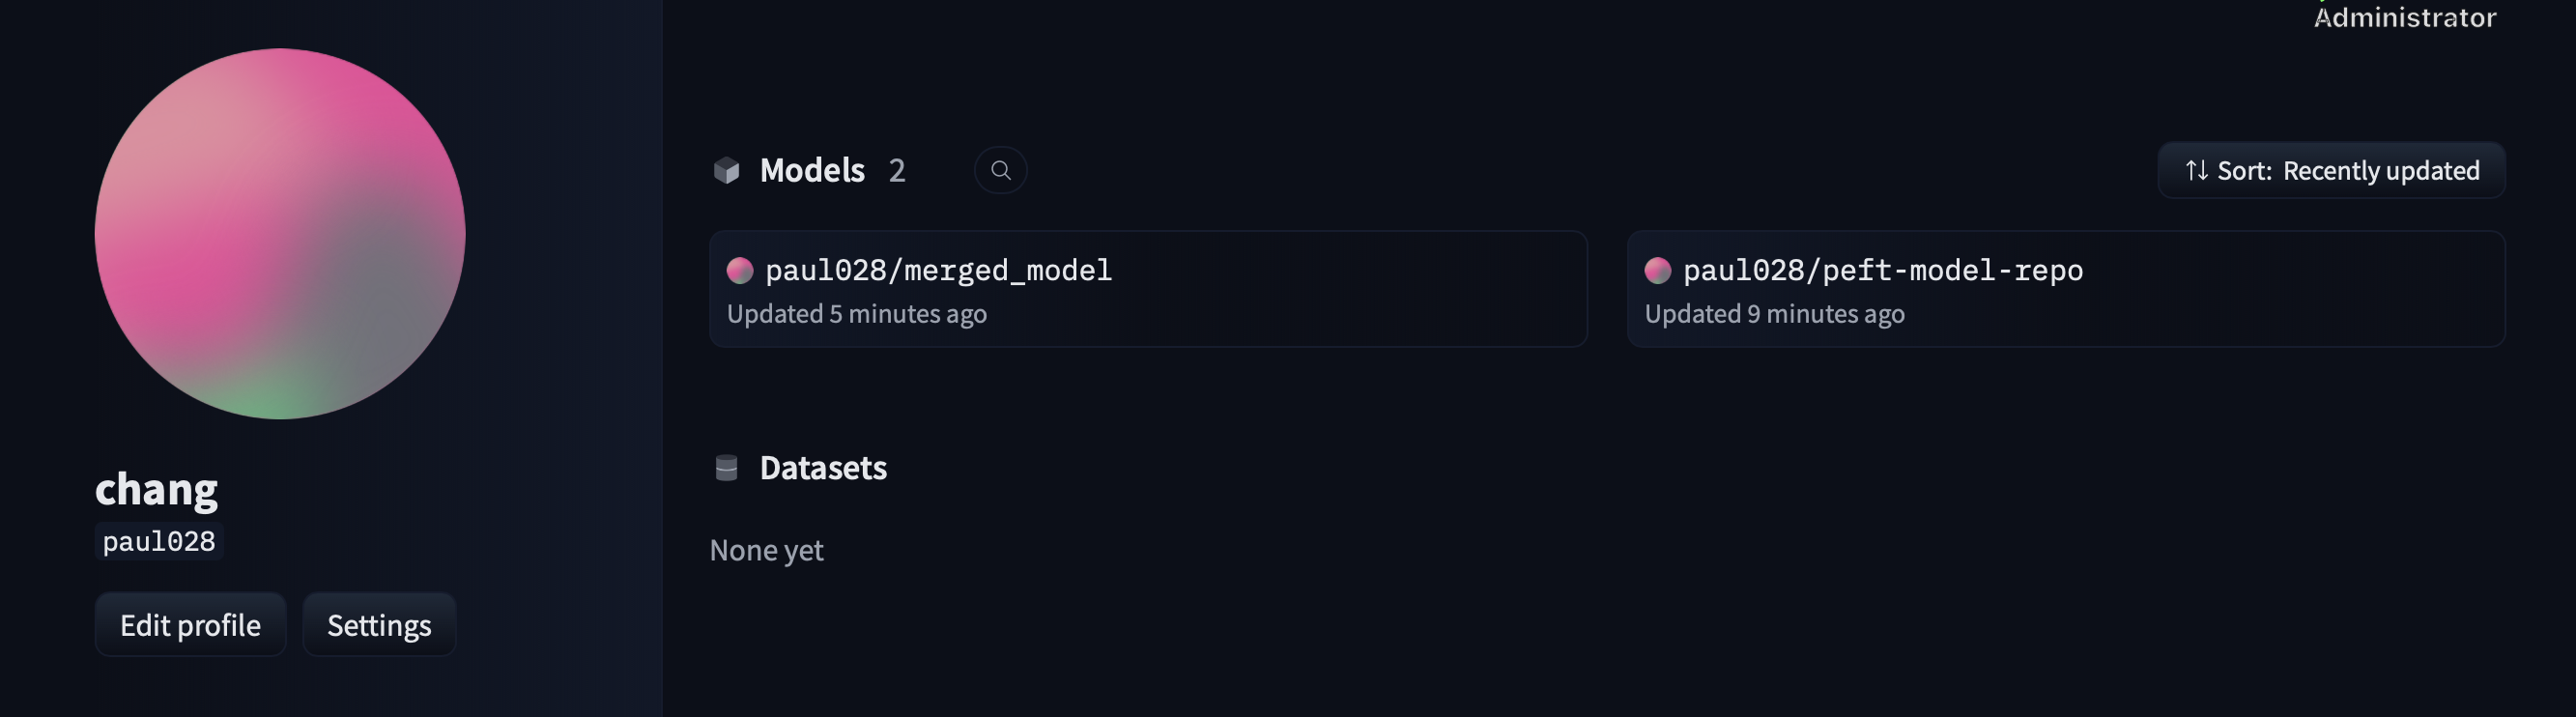